## Task 1: Principal Component Analysis (PCA)
This section focuses on dimensionality reduction, moving from high-dimensional data to a 2D space for visualization and efficiency while maintaining the integrity of the information.
## 1. Load or Create a Dataset
We will use the Wine Dataset, which has 13 features (dimensions). This is more complex than a simple 2D or 3D plot and allows us to see the power of PCA.

In [80]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load data
wine = load_wine()
X = wine.data
y = wine.target

# PCA is sensitive to scaling, so we must standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Original shape: {X.shape}")

Original shape: (178, 13)


## 2. Find the First 2 Principal Components (Manual vs. Scikit-Learn)
Manual Method (Eigendecomposition)
To compute without scikit-learn:

Calculate the Covariance Matrix
Find the Eigenvectors (directions of maximum variance)
Project the data onto the eigenvectors

In [81]:
# A) WITHOUT SKLEARN (Manual)
# 1. Compute covariance matrix
cov_matrix = np.cov(X_scaled.T)

# 2. Get eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
print("eigenvectors:", eigenvectors)
print("eigenvalues:", eigenvalues)


# 3. Sort eigenvectors by eigenvalues in descending order
idx = eigenvalues.argsort()[::-1]
eigenvectors = eigenvectors[:, idx]
print("sorted eigenvectors:", eigenvectors)

# 4. Project data onto the first 2 eigenvectors
X_pca_manual = X_scaled.dot(eigenvectors[:, :2])

# B) WITH SKLEARN
from sklearn.decomposition import PCA
pca = PCA(n_components=2)


X_pca_sklearn = pca.fit_transform(X_scaled)
print("Sklearn PCA:", X_pca_sklearn)

print("Manual PCA shape:", X_pca_manual.shape)
print("Sklearn PCA shape:", X_pca_sklearn.shape)

eigenvectors: [[-0.1443294   0.48365155 -0.20738262  0.0178563  -0.26566365  0.21353865
   0.05639636 -0.01496997  0.39613926 -0.26628645 -0.50861912 -0.22591696
   0.21160473]
 [ 0.24518758  0.22493093  0.08901289 -0.53689028  0.03521363  0.53681385
  -0.42052391 -0.02596375  0.06582674  0.12169604  0.07528304  0.07648554
  -0.30907994]
 [ 0.00205106  0.31606881  0.6262239   0.21417556 -0.14302547  0.15447466
   0.14917061  0.14121803 -0.17026002 -0.04962237  0.30769445 -0.49869142
  -0.02712539]
 [ 0.23932041 -0.0105905   0.61208035 -0.06085941  0.06610294 -0.10082451
   0.28696914 -0.09168285  0.42797018 -0.05574287 -0.20044931  0.47931378
   0.05279942]
 [-0.14199204  0.299634    0.13075693  0.35179658  0.72704851  0.03814394
  -0.3228833  -0.05677422 -0.15636143  0.06222011 -0.27140257  0.07128891
   0.06787022]
 [-0.39466085  0.06503951  0.14617896 -0.19806835 -0.14931841 -0.0841223
   0.02792498  0.46390791 -0.40593409 -0.30388245 -0.28603452  0.30434119
  -0.32013135]
 [-0.4229

## 3. Preserving a Certain Percentage of Variance
Instead of selecting a fixed number of components (e.g., 2), PCA can be configured to retain enough components to explain a specified percentage of the data's variance, such as 95%.

In [82]:
pca_95 = PCA(n_components=0.95)
X_reduced_95 = pca_95.fit_transform(X_scaled)

print(f"Components needed for 95% variance: {pca_95.n_components_}")

Components needed for 95% variance: 10


## 4. Train a Neural Network: Original vs. PCA
We use a Multi-Layer Perceptron (MLP) to compare model performance on the original dataset versus the PCA-transformed dataset.

In [83]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split original data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# a) Original Dataset
mlp_orig = MLPClassifier(max_iter=500, random_state=42)
mlp_orig.fit(X_train, y_train)
acc_orig = accuracy_score(y_test, mlp_orig.predict(X_test))

# b) PCA Components (using the 2 components found earlier)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca_sklearn, y, test_size=0.2, random_state=42)
mlp_pca = MLPClassifier(max_iter=500, random_state=42)
mlp_pca.fit(X_train_pca, y_train_pca)
acc_pca = accuracy_score(y_test_pca, mlp_pca.predict(X_test_pca))

print(f"Accuracy (Original - 13 features): {acc_orig:.4f}")
print(f"Accuracy (PCA - 2 features): {acc_pca:.4f}")

Accuracy (Original - 13 features): 1.0000
Accuracy (PCA - 2 features): 1.0000


## 5. Kernel PCA (Linear, Sigmoid, RBF)
Standard PCA captures only linear relationships. Kernel PCA applies the kernel trick to identify non-linear patterns, using kernels such as Linear, Sigmoid, and RBF.

In [84]:
from sklearn.decomposition import KernelPCA

# List of kernels to iterate through
# 'linear' is equivalent to standard PCA
# 'sigmoid' is inspired by neural networks
# 'rbf' (Radial Basis Function) is great for circular/complex clusters
kernels = ["linear", "sigmoid", "rbf"]

for k in kernels:
    # 1. Initialize KernelPCA with 2 components and the current kernel
    kpca = KernelPCA(n_components=2, kernel=k)
    X_kpca = kpca.fit_transform(X_scaled)

    # 2. Split the newly transformed data into training and testing sets
    X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(
        X_kpca, y, test_size=0.2, random_state=42
    )

    # 3. Initialize and train the MLP Classifier on the KPCA-transformed data
    # We increase max_iter to ensure the network converges
    mlp_k = MLPClassifier(max_iter=1000, random_state=42).fit(X_train_k, y_train_k)

    # 4. Predict and print the results
    predictions = mlp_k.predict(X_test_k)
    accuracy = accuracy_score(y_test_k, predictions)
    print(f"Kernel: {k:8} | Accuracy: {accuracy:.4f}")

Kernel: linear   | Accuracy: 1.0000
Kernel: sigmoid  | Accuracy: 1.0000
Kernel: rbf      | Accuracy: 1.0000


## 6. Hyperparameter Tuning Pipeline
We implement a Pipeline combined with GridSearchCV to simultaneously optimize the kernel selection and neural network hyperparameters.

In [85]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# 1. Define the Pipeline
# This sequences the steps: First apply KPCA, then feed the result into the MLP
pipeline = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    # ("mlp", MLPClassifier(max_iter=1000, random_state=42))
    ("log_reg", LogisticRegression(solver="lbfgs"))
])

# 2. Define the Parameter Grid
# Note the naming convention: 'stepname__parametername'
param_grid = {
    # Tuning KPCA: testing different kernels and the gamma (influence) parameter
    "kpca__kernel": ["linear", "rbf", "sigmoid"],
    "kpca__gamma": np.linspace(0.03, 0.05, 10),

    # # Tuning the Neural Network: testing different architectures and activations
    # "mlp__hidden_layer_sizes": [(50,), (100,), (50, 50)], # Try 1 or 2 hidden layers
    # "mlp__activation": ["relu", "tanh"] # Relu is standard, Tanh is often good for scaled data
}

# 3. Initialize GridSearchCV
# cv=3 means 3-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1) # n_jobs=-1 uses all CPU cores

# 4. Run the search on the scaled data
grid_search.fit(X_train_pca, y_train_pca)

# 5. Output the best combination found
print("Best Parameters Found:")
print(grid_search.best_params_)

# 6. Output the best score achieved during training
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

Best Parameters Found:
{'kpca__gamma': np.float64(0.03), 'kpca__kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.9648


In [86]:
grid_search.best_estimator_.fit(X_train_pca, y_train_pca)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('kpca', ...), ('log_reg', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"n_components n_components: int, default=NoneNumber of components. If None, all non-zero components are kept.",2
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'cosine', 'precomputed'} or callable, default='linear'Kernel used for PCA.",'rbf'
,"gamma gamma: float, default=NoneKernel coefficient for rbf, poly and sigmoid kernels. Ignored by otherkernels. If ``gamma`` is ``None``, then it is set to ``1/n_features``.",np.float64(0.03)
,"degree degree: float, default=3Degree for poly kernels. Ignored by other kernels.",3
,"coef0 coef0: float, default=1Independent term in poly and sigmoid kernels.Ignored by other kernels.",1
,"kernel_params kernel_params: dict, default=NoneParameters (keyword arguments) andvalues for kernel passed as callable object.Ignored by other kernels.",None
,"alpha alpha: float, default=1.0Hyperparameter of the ridge regression that learns theinverse transform (when fit_inverse_transform=True).",1.0


In [87]:
y_pred = grid_search.best_estimator_.predict(X_test_pca)

accuracy_score(y_test_pca, y_pred)

0.9722222222222222

In [88]:
from sklearn.model_selection import ShuffleSplit, LearningCurveDisplay

def draw_learning_curve(model, X, y, title):
    common_params = {
        "X": X,
        "y": y,
        "train_sizes": np.linspace(0.1, 1.0, 5),
        "cv": ShuffleSplit(n_splits=10, test_size=0.2, random_state=0),
        "score_type": "both",
        "score_name": "Accuracy",
        "line_kw": {"marker": "o"},
        "std_display_style": 'fill_between',
    }
    fig, ax = plt.subplots(figsize=(8, 5))
    plt.subplots_adjust(hspace=0.5)

    LearningCurveDisplay.from_estimator(model, **common_params, ax=ax)
    handles, label = ax.get_legend_handles_labels()
    ax.legend(handles[:2], ["Train Score", "Test Score"])
    ax.set_title(title)
    ax.set_xlabel("Set size")
    ax.grid(True)

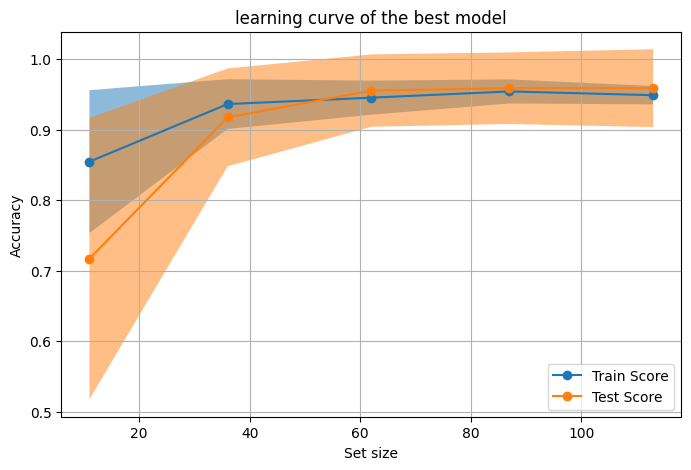

In [89]:
draw_learning_curve(grid_search.best_estimator_, X_train_pca, y_train_pca, 'learning curve of the best model')